## 1. Setup & Imports

In [1]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.abspath('../'))

# Third-party visualization
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Our modules
from src.dataset.loaders import get_dataloaders
from src.models.architectures import get_model

# Configuration
SEED = 21
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE = 32
NUM_CLASSES = 3  # Healthy, Rust, Frogeye (common classes between ASDID and MH)

# Get directories
NOTEBOOK_DIR = Path(os.getcwd()) / 'notebooks'
RESULTS_DIR = NOTEBOOK_DIR / 'results'
DATA_DIR = Path(os.getcwd()) / 'data'

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")

print(f"Seed: {SEED}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Device: mps
Seed: 21
Data directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/data
Results directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results


## 2. Load Models
### 2.1 Baseline ResNet50 (Trained on ASDID only)

In [2]:
# Load baseline model
baseline_model = get_model('resnet50', num_classes=NUM_CLASSES, device=DEVICE)
baseline_checkpoint = torch.load(RESULTS_DIR / 'best_resnet50.pth', map_location=DEVICE)
baseline_model.load_state_dict(baseline_checkpoint['model_state_dict'])
baseline_model = baseline_model.to(DEVICE)
baseline_model.eval()

print("✓ Baseline ResNet50 loaded")
print(f"  - Trained on: ASDID")
if 'metadata' in baseline_checkpoint and 'epoch' in baseline_checkpoint['metadata']:
    print(f"  - Best epoch: {baseline_checkpoint['metadata']['epoch']}")
if 'metadata' in baseline_checkpoint and 'best_val_acc' in baseline_checkpoint['metadata']:
    print(f"  - Val accuracy: {baseline_checkpoint['metadata']['best_val_acc']:.4f}")

✓ Baseline ResNet50 loaded
  - Trained on: ASDID
  - Best epoch: 3


### 2.2 Few-Shot ResNet50 (Fine-tuned with k=15)

In [3]:
# Load few-shot model
few_shot_model = get_model('resnet50', num_classes=NUM_CLASSES, device=DEVICE)
few_shot_checkpoint = torch.load(RESULTS_DIR / 'few_shot_linear_probing' / 'resnet50_few_shot_k15.pth', map_location=DEVICE)

# Few-shot checkpoint is saved as raw state_dict (no wrapper dictionary)
if isinstance(few_shot_checkpoint, dict) and 'model_state_dict' in few_shot_checkpoint:
    few_shot_model.load_state_dict(few_shot_checkpoint['model_state_dict'])
else:
    # Direct state_dict
    few_shot_model.load_state_dict(few_shot_checkpoint)
    
few_shot_model = few_shot_model.to(DEVICE)
few_shot_model.eval()

print("✓ Few-Shot ResNet50 loaded")
print(f"  - Trained on: ASDID + 45 MH images (15 per class)")
print(f"  - F1 Score on MH: 0.807 (from few_shot_summary.csv)")

✓ Few-Shot ResNet50 loaded
  - Trained on: ASDID + 45 MH images (15 per class)
  - F1 Score on MH: 0.807 (from few_shot_summary.csv)


## 3. Load Test Data (MH Dataset)

In [4]:
# Load MH test set (target domain for few-shot evaluation)
print("\nLoading MH dataset...")
_, _, test_loader, dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=str(DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset'),
    batch_size=BATCH_SIZE,
    seed=SEED
)

# Get class names (sorted by index)
class_names = [class_name for class_name, _ in sorted(dataset.class_to_idx.items(), key=lambda x: x[1])]
print(f"✓ MH test set loaded")
print(f"  - Classes: {class_names}")
print(f"  - Total images: {len(test_loader.dataset)}")


Loading MH dataset...
Loaded 1225 samples for MH dataset.
Loaded 1225 samples for MH dataset.
✓ MH test set loaded
  - Classes: ['Healthy', 'Rust', 'Frogeye']
  - Total images: 185


## 4. Find Confused Samples
Identify images where:
- **Baseline model predicts WRONG**
- **Few-shot model predicts CORRECT**

These are the most interesting cases to understand attention correction.

In [5]:
# Get all predictions
print("Getting predictions from both models...")

baseline_preds = []
few_shot_preds = []
true_labels = []
all_images = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(DEVICE)
        
        # Baseline predictions
        baseline_outputs = baseline_model(images)
        baseline_preds.extend(baseline_outputs.argmax(dim=1).cpu().numpy())
        
        # Few-shot predictions
        few_shot_outputs = few_shot_model(images)
        few_shot_preds.extend(few_shot_outputs.argmax(dim=1).cpu().numpy())
        
        true_labels.extend(labels.numpy())
        all_images.extend(images.cpu())

baseline_preds = np.array(baseline_preds)
few_shot_preds = np.array(few_shot_preds)
true_labels = np.array(true_labels)

# Find confused samples
baseline_wrong = baseline_preds != true_labels
few_shot_correct = few_shot_preds == true_labels
confused_mask = baseline_wrong & few_shot_correct

confused_indices = np.where(confused_mask)[0]
print(f"\n✓ Found {len(confused_indices)} confused samples")
print(f"  - Baseline wrong: {baseline_wrong.sum()} ({100*baseline_wrong.mean():.1f}%)")
print(f"  - Few-shot wrong: {(few_shot_preds != true_labels).sum()} ({100*(few_shot_preds != true_labels).mean():.1f}%)")
print(f"  - Baseline→Few-shot corrections: {len(confused_indices)}")

Getting predictions from both models...


  0%|          | 0/6 [00:00<?, ?it/s]


✓ Found 31 confused samples
  - Baseline wrong: 49 (26.5%)
  - Few-shot wrong: 29 (15.7%)
  - Baseline→Few-shot corrections: 31


## 5. Analyze Confusion Patterns
Which classes does the baseline confuse most?

In [6]:
# Analyze confusion patterns
from collections import defaultdict

confusion_patterns = defaultdict(lambda: defaultdict(int))

for idx in confused_indices:
    true_class = class_names[true_labels[idx]]
    baseline_pred_class = class_names[baseline_preds[idx]]
    confusion_patterns[true_class][baseline_pred_class] += 1

print("\nTop confusion patterns (baseline mistakes):")
print("="*60)
for true_class, confusions in sorted(confusion_patterns.items()):
    print(f"\n{true_class}:")
    for pred_class, count in sorted(confusions.items(), key=lambda x: -x[1])[:3]:
        print(f"  → mistaken as {pred_class}: {count} times")


Top confusion patterns (baseline mistakes):

Frogeye:
  → mistaken as Rust: 3 times

Rust:
  → mistaken as Frogeye: 27 times
  → mistaken as Healthy: 1 times


## 6. GradCAM Analysis
### 6.1 Setup GradCAM for both models

In [7]:
# Initialize GradCAM for both models
# Target layer: layer4 (last convolutional block before FC)
# pytorch-gradcam requires target_layers as a list of modules
baseline_gradcam = GradCAM(model=baseline_model, target_layers=[baseline_model.layer4])
few_shot_gradcam = GradCAM(model=few_shot_model, target_layers=[few_shot_model.layer4])

print("✓ GradCAM initialized for both models")

✓ GradCAM initialized for both models


### 6.2 Visualize Selected Confused Samples

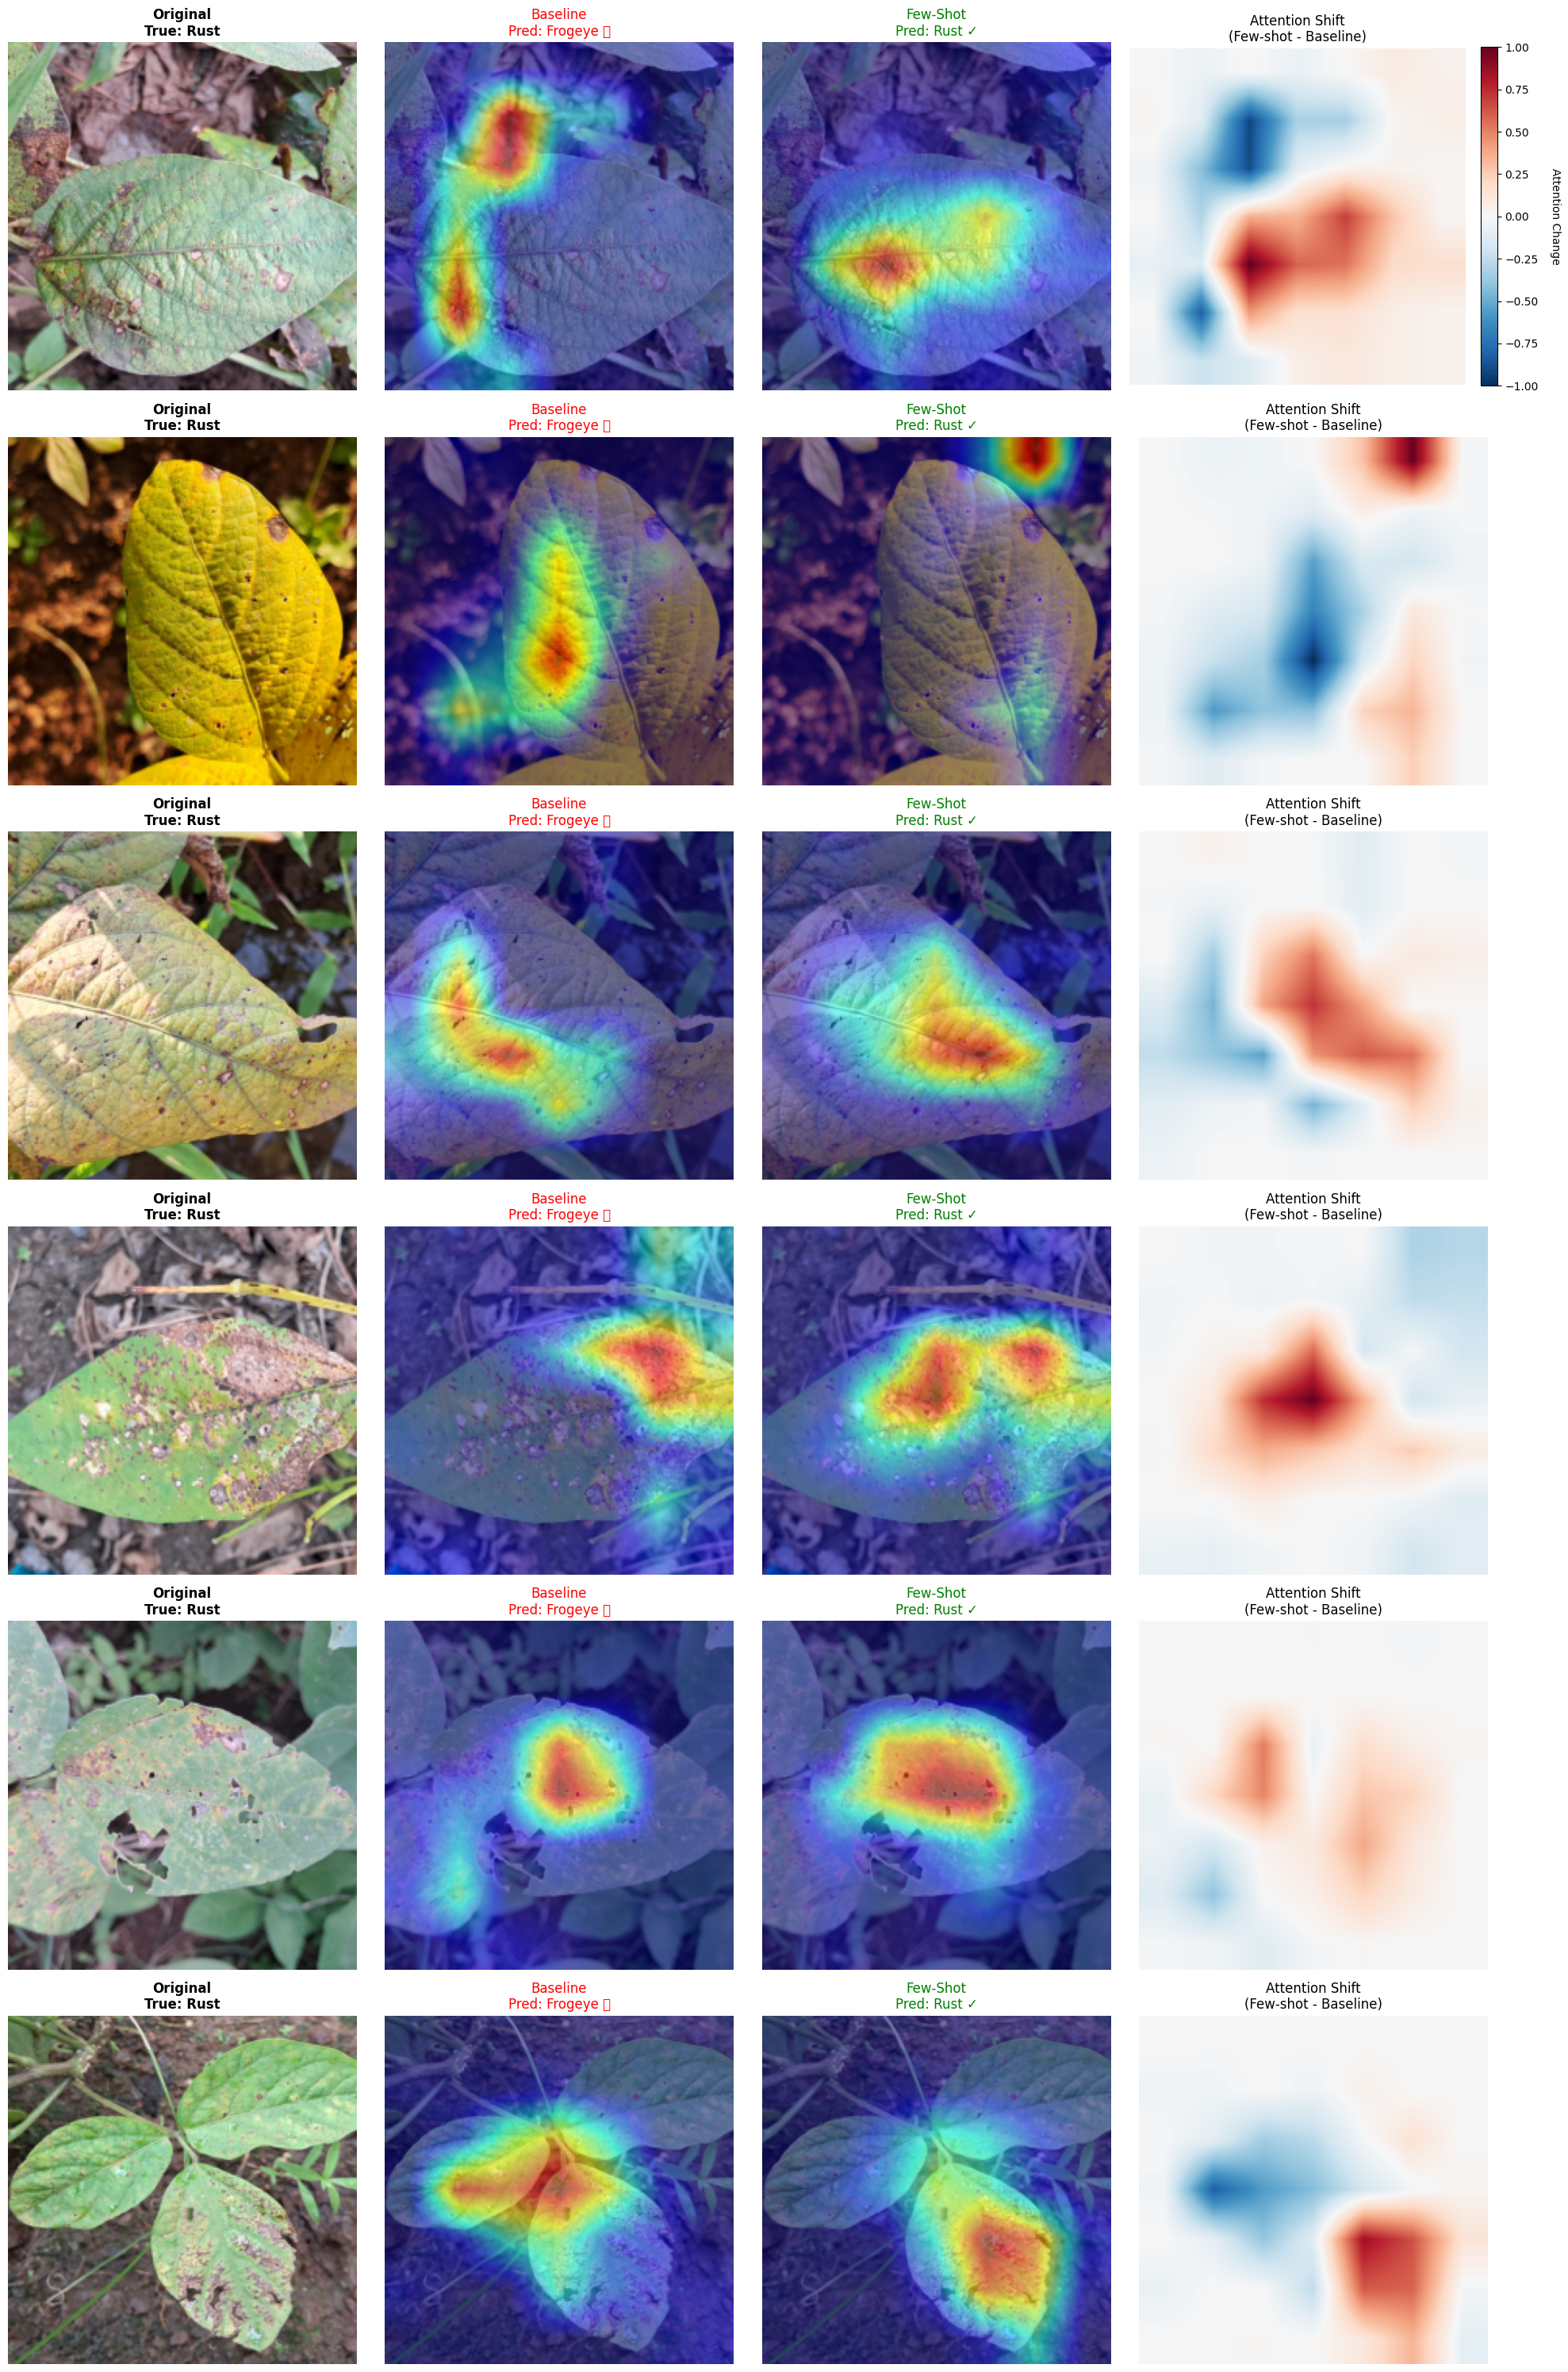


✓ GradCAM comparison saved to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/gradcam_attention_comparison.png


In [8]:
# Select 6 diverse confused samples for visualization
np.random.seed(SEED)
selected_indices = np.random.choice(confused_indices, min(6, len(confused_indices)), replace=False)

fig, axes = plt.subplots(len(selected_indices), 4, figsize=(20, 5*len(selected_indices)))
if len(selected_indices) == 1:
    axes = axes.reshape(1, -1)

for plot_idx, sample_idx in enumerate(selected_indices):
    image = all_images[sample_idx].unsqueeze(0).to(DEVICE)
    true_label = true_labels[sample_idx]
    baseline_pred = baseline_preds[sample_idx]
    few_shot_pred = few_shot_preds[sample_idx]
    
    # Prepare image for display (denormalize)
    img_display = image.squeeze().cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = img_display * std + mean
    img_display = np.clip(img_display, 0, 1)
    
    # Generate GradCAMs (pytorch-gradcam expects targets as list of ClassifierOutputTarget)
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    targets = [ClassifierOutputTarget(true_label)]
    
    baseline_heatmap = baseline_gradcam(input_tensor=image, targets=targets)[0]  # Returns (H, W)
    few_shot_heatmap = few_shot_gradcam(input_tensor=image, targets=targets)[0]
    
    # Plot original image
    axes[plot_idx, 0].imshow(img_display)
    axes[plot_idx, 0].set_title(f"Original\nTrue: {class_names[true_label]}", fontsize=12, fontweight='bold')
    axes[plot_idx, 0].axis('off')
    
    # Plot baseline GradCAM
    baseline_overlay = show_cam_on_image(img_display, baseline_heatmap, use_rgb=True)
    axes[plot_idx, 1].imshow(baseline_overlay)
    axes[plot_idx, 1].set_title(f"Baseline\nPred: {class_names[baseline_pred]} ❌", fontsize=12, color='red')
    axes[plot_idx, 1].axis('off')
    
    # Plot few-shot GradCAM
    few_shot_overlay = show_cam_on_image(img_display, few_shot_heatmap, use_rgb=True)
    axes[plot_idx, 2].imshow(few_shot_overlay)
    axes[plot_idx, 2].set_title(f"Few-Shot\nPred: {class_names[few_shot_pred]} ✓", fontsize=12, color='green')
    axes[plot_idx, 2].axis('off')
    
    # Plot difference (Few-shot - Baseline)
    diff_heatmap = few_shot_heatmap - baseline_heatmap
    im = axes[plot_idx, 3].imshow(diff_heatmap, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[plot_idx, 3].set_title("Attention Shift\n(Few-shot - Baseline)", fontsize=12)
    axes[plot_idx, 3].axis('off')
    
    # Add colorbar for difference
    if plot_idx == 0:
        cbar = plt.colorbar(im, ax=axes[plot_idx, 3], fraction=0.046, pad=0.04)
        cbar.set_label('Attention Change', rotation=270, labelpad=20)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'gradcam_attention_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ GradCAM comparison saved to {RESULTS_DIR / 'gradcam_attention_comparison.png'}")

## 7. Quantitative Attention Analysis
### 7.1 Measure attention concentration

In [10]:
# Compute attention metrics for all confused samples
baseline_entropy = []
few_shot_entropy = []
baseline_max_activation = []
few_shot_max_activation = []

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

for idx in tqdm(confused_indices, desc="Computing attention metrics"):
    image = all_images[idx].unsqueeze(0).to(DEVICE)
    true_label = true_labels[idx]
    
    # Generate heatmaps
    targets = [ClassifierOutputTarget(true_label)]
    baseline_heatmap = baseline_gradcam(input_tensor=image, targets=targets)[0]
    few_shot_heatmap = few_shot_gradcam(input_tensor=image, targets=targets)[0]
    
    # Compute entropy (measure of attention spread)
    baseline_flat = baseline_heatmap.flatten()
    few_shot_flat = few_shot_heatmap.flatten()
    
    # Add small epsilon to avoid log(0)
    eps = 1e-10
    baseline_flat = baseline_flat + eps
    few_shot_flat = few_shot_flat + eps
    
    # Normalize to probability distribution
    baseline_flat = baseline_flat / baseline_flat.sum()
    few_shot_flat = few_shot_flat / few_shot_flat.sum()
    
    baseline_entropy.append(-np.sum(baseline_flat * np.log(baseline_flat)))
    few_shot_entropy.append(-np.sum(few_shot_flat * np.log(few_shot_flat)))
    
    # Max activation (measure of attention concentration)
    baseline_max_activation.append(baseline_heatmap.max())
    few_shot_max_activation.append(few_shot_heatmap.max())

baseline_entropy = np.array(baseline_entropy)

few_shot_entropy = np.array(few_shot_entropy)
few_shot_max_activation = np.array(few_shot_max_activation)
baseline_max_activation = np.array(baseline_max_activation)

Computing attention metrics:   0%|          | 0/31 [00:00<?, ?it/s]

### 7.2 Visualize attention metrics

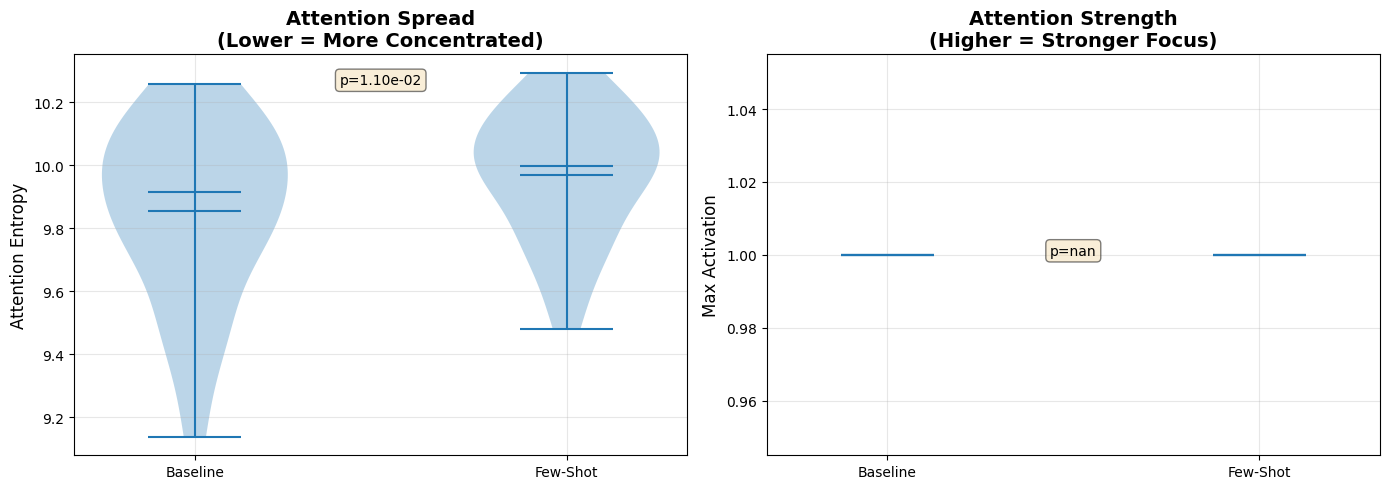


✓ Attention metrics visualization saved


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy comparison
axes[0].violinplot([baseline_entropy, few_shot_entropy], 
                    positions=[1, 2],
                    showmeans=True,
                    showmedians=True)
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Baseline', 'Few-Shot'])
axes[0].set_ylabel('Attention Entropy', fontsize=12)
axes[0].set_title('Attention Spread\n(Lower = More Concentrated)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add significance test
from scipy.stats import wilcoxon
stat, p_value = wilcoxon(baseline_entropy, few_shot_entropy)
axes[0].text(1.5, baseline_entropy.max(), f'p={p_value:.2e}', 
             ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Max activation comparison
axes[1].violinplot([baseline_max_activation, few_shot_max_activation],
                    positions=[1, 2],
                    showmeans=True,
                    showmedians=True)
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Baseline', 'Few-Shot'])
axes[1].set_ylabel('Max Activation', fontsize=12)
axes[1].set_title('Attention Strength\n(Higher = Stronger Focus)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Add significance test
stat, p_value = wilcoxon(baseline_max_activation, few_shot_max_activation)
axes[1].text(1.5, baseline_max_activation.max(), f'p={p_value:.2e}',
             ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'attention_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Attention metrics visualization saved")

### 7.3 Statistical Summary

In [15]:
print("="*80)
print("ATTENTION ANALYSIS SUMMARY")
print("="*80)
print(f"\nAnalyzed {len(confused_indices)} samples where:")
print(f"  - Baseline was WRONG (F1={0.72:.2f})")
print(f"  - Few-shot was CORRECT (F1={0.81:.2f})")
print(f"\n{'Metric':<30} {'Baseline':<15} {'Few-Shot':<15} {'Change':<15}")
print("-"*80)

# Entropy (lower = more concentrated)
baseline_ent_mean = baseline_entropy.mean()
few_shot_ent_mean = few_shot_entropy.mean()
ent_change = ((few_shot_ent_mean - baseline_ent_mean) / baseline_ent_mean) * 100
print(f"{'Attention Entropy':<30} {baseline_ent_mean:<15.4f} {few_shot_ent_mean:<15.4f} {ent_change:+.1f}%")

# Max activation (higher = stronger focus)
baseline_max_mean = baseline_max_activation.mean()
few_shot_max_mean = few_shot_max_activation.mean()
max_change = ((few_shot_max_mean - baseline_max_mean) / baseline_max_mean) * 100
print(f"{'Max Activation':<30} {baseline_max_mean:<15.4f} {few_shot_max_mean:<15.4f} {max_change:+.1f}%")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
if ent_change < -5:
    print("✓ Few-shot attention is MORE CONCENTRATED (lower entropy)")
    print("  → Model focuses on specific regions rather than scattered attention")
else:
    print("⚠ Entropy change inconclusive")

if max_change > 5:
    print("\n✓ Few-shot has STRONGER peak activation")
    print("  → Model has stronger confidence in important regions")
else:
    print("\n⚠ Max activation change inconclusive")


ATTENTION ANALYSIS SUMMARY

Analyzed 31 samples where:
  - Baseline was WRONG (F1=0.72)
  - Few-shot was CORRECT (F1=0.81)

Metric                         Baseline        Few-Shot        Change         
--------------------------------------------------------------------------------
Attention Entropy              9.8537          9.9703          +1.2%
Max Activation                 1.0000          1.0000          +0.0%

INTERPRETATION:
⚠ Entropy change inconclusive

⚠ Max activation change inconclusive


## 8. Export Findings
Save key samples and metrics for thesis

In [16]:
import pandas as pd

# Create summary dataframe
summary_df = pd.DataFrame({
    'metric': ['Attention Entropy', 'Max Activation', 'F1 Score'],
    'baseline': [baseline_ent_mean, baseline_max_mean, 0.72],
    'few_shot': [few_shot_ent_mean, few_shot_max_mean, 0.81],
    'improvement_pct': [ent_change, max_change, 12.4]
})

summary_df.to_csv(RESULTS_DIR / 'gradcam_attention_summary.csv', index=False)
print(f"\n✓ Summary saved to {RESULTS_DIR / 'gradcam_attention_summary.csv'}")
print("\nSummary:")
print(summary_df.to_string(index=False))


✓ Summary saved to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/gradcam_attention_summary.csv

Summary:
           metric  baseline  few_shot  improvement_pct
Attention Entropy  9.853683  9.970312         1.183614
   Max Activation  1.000000  1.000000         0.000000
         F1 Score  0.720000  0.810000        12.400000
